In [5]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from pathlib import Path

In [3]:
image_path = Path("Sugarcane Dataset")

Data Exploration

In [3]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 5 directories and 0 images in 'Sugarcane Dataset'.
There are 0 directories and 522 images in 'Sugarcane Dataset\Healthy'.
There are 0 directories and 462 images in 'Sugarcane Dataset\Mosaic'.
There are 0 directories and 518 images in 'Sugarcane Dataset\RedRot'.
There are 0 directories and 514 images in 'Sugarcane Dataset\Rust'.
There are 0 directories and 505 images in 'Sugarcane Dataset\Yellow'.


Random Image Path: Sugarcane Dataset\RedRot\redrot (419).jpeg
Image Class: RedRot
Image Height: 1040
Image Width: 493


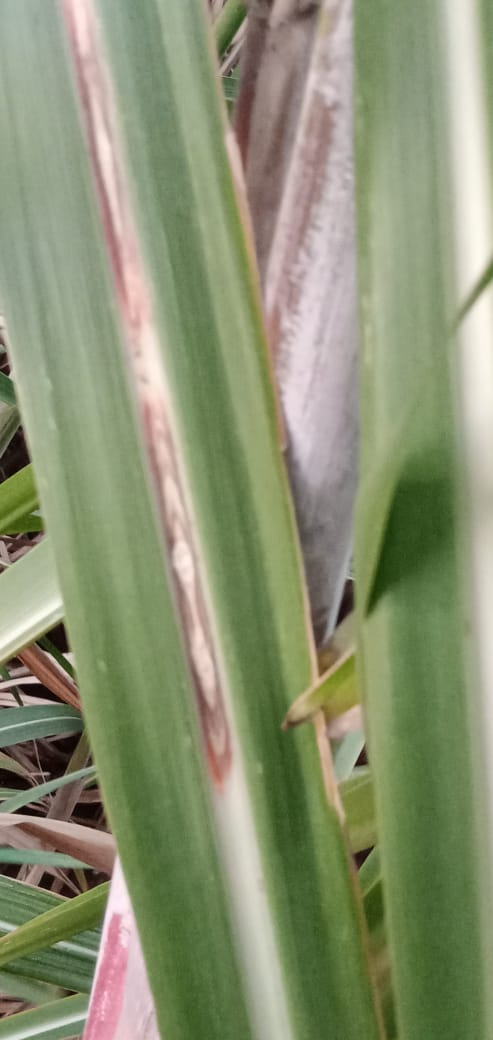

In [6]:
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*.jpeg"))

random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random Image Path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
img

(-0.5, 492.5, 1039.5, -0.5)

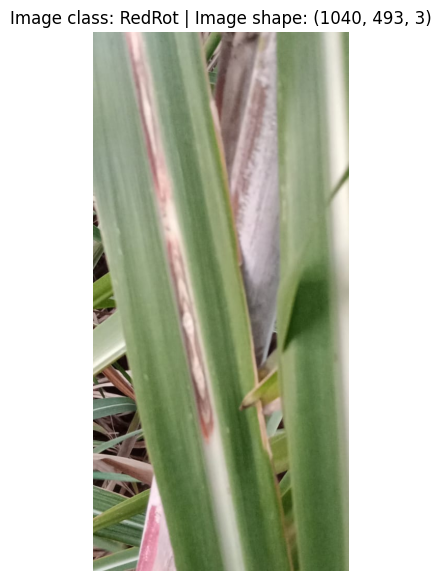

In [7]:
img_as_array = np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}")
plt.axis(False)

In [8]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor()
])

custom_dataset = datasets.ImageFolder(root=image_path, transform=transform)
loader = torch.utils.data.DataLoader(custom_dataset, batch_size=32, shuffle=False, num_workers=2)

mean = 0.0
std = 0.0
total_images_count = 0

for images, _ in loader:
    batch_images_count = images.size(0)
    images = images.view(batch_images_count, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images_count += batch_images_count

mean /= total_images_count
std /= total_images_count

print(f'Mean: {mean}')
print(f'Std: {std}')


Mean: tensor([0.4977, 0.5281, 0.3800])
Std: tensor([0.1744, 0.1733, 0.1814])


Transforming Data


In [11]:
from torchvision.transforms import v2

transforms = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.RandomVerticalFlip(),
    v2.RandomHorizontalFlip(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean, std) 
])
img_path = Image.open('Sugarcane Dataset\Mosaic\mosaic (6).jpeg')
transformed_image = transforms(img_path)
transformed_image

Image([[[-0.3803, -0.6727, -1.0551,  ..., -0.8077, -0.7852, -0.7402],
        [-0.2679, -0.5378, -0.8977,  ..., -0.8527, -0.7852, -0.7627],
        [-0.2004, -0.4253, -0.7177,  ..., -0.8527, -0.8077, -0.7852],
        ...,
        [-1.8648, -1.6849, -1.4600,  ...,  0.0695,  0.0245,  0.0245],
        [-1.8648, -1.7074, -1.5274,  ...,  0.0695,  0.0245,  0.0920],
        [-1.8198, -1.7299, -1.5949,  ...,  0.0470,  0.0245,  0.1145]],

       [[-1.2594, -1.4857, -1.7119,  ..., -1.2142, -1.0558, -0.9427],
        [-1.1916, -1.3952, -1.5988,  ..., -1.2821, -1.0784, -0.9653],
        [-1.1237, -1.3047, -1.4631,  ..., -1.3047, -1.1011, -0.9879],
        ...,
        [-2.3454, -2.2097, -2.0061,  ..., -0.6938, -0.7164, -0.7391],
        [-2.3454, -2.2323, -2.0739,  ..., -0.7164, -0.7391, -0.6938],
        [-2.3228, -2.2549, -2.1418,  ..., -0.7617, -0.7391, -0.6938]],

       [[-1.0786, -1.2083, -1.2948,  ..., -1.5758, -1.5974, -1.5542],
        [-1.0570, -1.2083, -1.2515,  ..., -1.5758, -1.5974, 

In [12]:
transforms(img).shape

torch.Size([3, 224, 224])

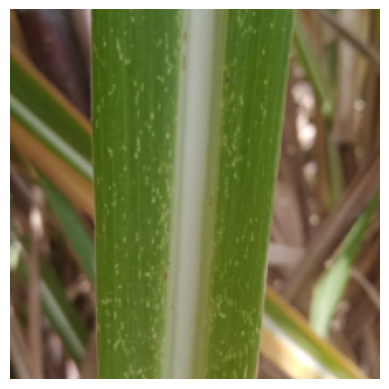

In [13]:
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor
transformed_image = denormalize(transformed_image, mean, std)
transformed_image = transformed_image.numpy().transpose((1, 2, 0))
plt.imshow(transformed_image)
plt.axis('off')
plt.show()


In [14]:
dataset = datasets.ImageFolder(root=image_path, transform = transforms)
train_ratio = 0.8
test_ratio = 0.2
classes = dataset.classes
classes

['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, Subset
targets = [label for _, label in dataset.samples]

train_ratio = 0.8
test_ratio = 0.2

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio, train_size=train_ratio)

train_indices, test_indices = next(strat_split.split(np.zeros(len(targets)), targets))

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of testing samples: {len(test_dataset)}')


train_targets = [targets[i] for i in train_indices]
test_targets = [targets[i] for i in test_indices]

print(f'Training set class distribution: {np.bincount(train_targets)}')
print(f'Testing set class distribution: {np.bincount(test_targets)}')

Number of training samples: 2016
Number of testing samples: 505
Training set class distribution: [417 370 414 411 404]
Testing set class distribution: [105  92 104 103 101]


In [16]:
class_dict = dataset.class_to_idx
class_dict

{'Healthy': 0, 'Mosaic': 1, 'RedRot': 2, 'Rust': 3, 'Yellow': 4}

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [18]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*53*53,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        self.dropout = nn.Dropout(0.5)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = Net()

In [19]:
from torchvision import datasets, transforms, models
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [21]:
best_accuracy = 0
patience = 5 
patience_counter = 0

for epoch in range(30):  
    model.train()  
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step() 
    accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1} - Loss: {running_loss / len(train_loader):.3f}, Accuracy: {accuracy:.2f}%')

   
    model.eval() 
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping")
        break

print('Finished Training')


Epoch 1 - Loss: 0.411, Accuracy: 84.87%
Test Accuracy: 77.43%
Epoch 2 - Loss: 0.411, Accuracy: 85.07%
Test Accuracy: 77.62%
Epoch 3 - Loss: 0.421, Accuracy: 85.32%
Test Accuracy: 76.63%
Epoch 4 - Loss: 0.411, Accuracy: 84.57%
Test Accuracy: 78.42%
Epoch 5 - Loss: 0.402, Accuracy: 85.52%
Test Accuracy: 78.61%
Epoch 6 - Loss: 0.431, Accuracy: 85.17%
Test Accuracy: 77.23%
Epoch 7 - Loss: 0.402, Accuracy: 85.22%
Test Accuracy: 77.62%
Epoch 8 - Loss: 0.425, Accuracy: 84.28%
Test Accuracy: 77.82%
Epoch 9 - Loss: 0.414, Accuracy: 85.32%
Test Accuracy: 77.62%
Epoch 10 - Loss: 0.422, Accuracy: 84.87%
Test Accuracy: 76.83%
Early stopping
Finished Training


In [18]:
PATH = './Model_State_Dict.pth'
torch.save(model.state_dict(), PATH)

In [21]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [22]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 80 %


In [23]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Healthy is 81.0 %
Accuracy for class: Mosaic is 68.5 %
Accuracy for class: RedRot is 77.9 %
Accuracy for class: Rust  is 82.5 %
Accuracy for class: Yellow is 84.2 %
